# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

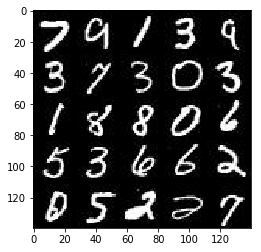

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

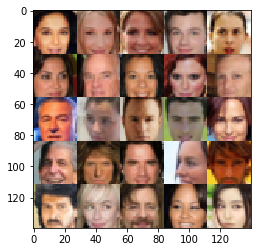

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = [image_width, image_height, image_channels]
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        
        #x0 = tf.layers.conv2d(images, 64, 3, strides=1, padding='same')
        #relu0 = tf.maximum(alpha * x0, x0)
        # 28x28x64
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
 
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
               
        #xm = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        #xm = tf.layers.batch_normalization(xm, training=is_train)
        #xm = tf.maximum(alpha * xm, xm)
        # 7x7x128 now
            
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
         
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    d_smooth = 0.1 #label smoothing for the discriminator for real images
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - d_smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs [x]
    :param batch_size: Batch Size [x]
    :param z_dim: Z dimension [x]
    :param learning_rate: Learning Rate [x]
    :param beta1: The exponential decay rate for the 1st moment in the optimizer [x]
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data [x]
    :param data_image_mode: The image mode to use for images ("RGB" or "L") [x]
    """
    batch_count = 0
    show_every = 200
    print_every = 50

    print(data_shape)
    _, image_width, image_height, image_channels = data_shape
    # TODO: Build Model
    
    # prepare input
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    # prepare loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    # prepare optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    #train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_count += 1
                
                # Scale batch_images equivalent to Samples
                batch_images = batch_images * 2.0 #Data was from -0.5 to 0.5
                
                #another way of scalgin
                #batch_images = ((batch_images - batch_images.min())/(0.5 - batch_images.min()))
                #scale_max = +1
                #scale_min = -1
                #batch_images = batch_images * (scale_max - scale_min) + scale_min
                
                # Sample noise from G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z, 
                                                     lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z, 
                                                     lr:learning_rate})

                if batch_count % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if batch_count % show_every == 0:
                    show_generator_output(sess, 
                                          n_images = 16, 
                                          input_z = input_z, 
                                          out_channel_dim = image_channels, 
                                          image_mode = data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 1.8748... Generator Loss: 0.3034
Epoch 1/2... Discriminator Loss: 1.7260... Generator Loss: 2.0104
Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.5176


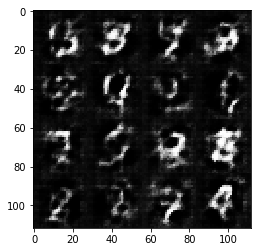

Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.5069
Epoch 1/2... Discriminator Loss: 1.5932... Generator Loss: 0.4491
Epoch 1/2... Discriminator Loss: 1.2957... Generator Loss: 0.6520


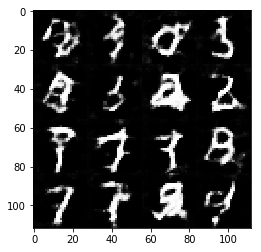

Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 1.0279
Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 0.5167
Epoch 1/2... Discriminator Loss: 1.1050... Generator Loss: 0.9234
Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 0.7371


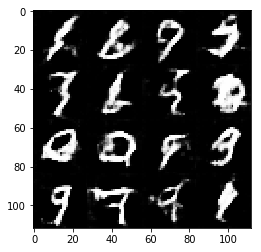

Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.8523
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 0.9168
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 0.8114
Epoch 1/2... Discriminator Loss: 1.4388... Generator Loss: 1.9813


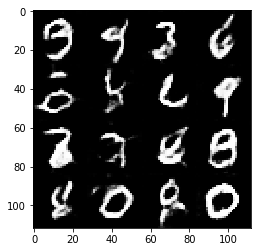

Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 0.9850
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 1.5563... Generator Loss: 0.4488
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.5355


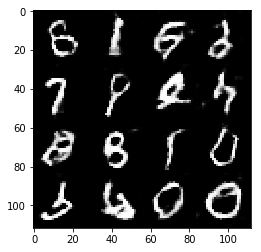

Epoch 1/2... Discriminator Loss: 1.7247... Generator Loss: 0.3551
Epoch 1/2... Discriminator Loss: 1.1885... Generator Loss: 1.0950
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 1.6881
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 0.6476


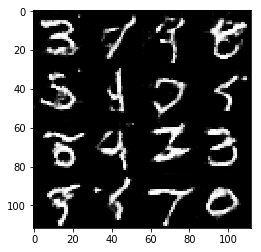

Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 0.8880
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 1.7536
Epoch 1/2... Discriminator Loss: 1.8155... Generator Loss: 0.3472
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.5228


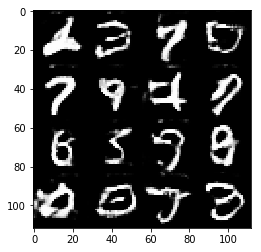

Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 0.8812
Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 1.0653
Epoch 1/2... Discriminator Loss: 1.0664... Generator Loss: 1.7130
Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 1.7468


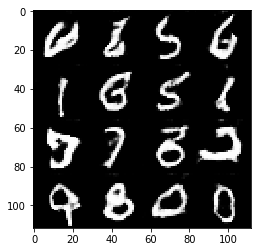

Epoch 1/2... Discriminator Loss: 0.8271... Generator Loss: 1.2319
Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 1.0524
Epoch 1/2... Discriminator Loss: 0.9446... Generator Loss: 1.2717
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.6446


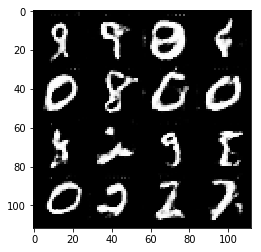

Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 0.9774
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.0445
Epoch 2/2... Discriminator Loss: 0.9641... Generator Loss: 0.9343
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.7631


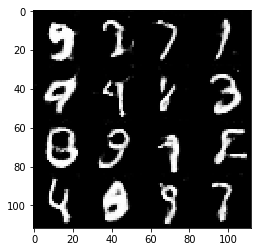

Epoch 2/2... Discriminator Loss: 1.0841... Generator Loss: 0.7870
Epoch 2/2... Discriminator Loss: 1.1404... Generator Loss: 0.8757
Epoch 2/2... Discriminator Loss: 0.9762... Generator Loss: 0.9293
Epoch 2/2... Discriminator Loss: 0.8410... Generator Loss: 1.2168


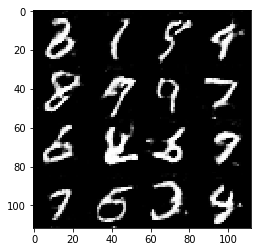

Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 1.6396... Generator Loss: 0.3951
Epoch 2/2... Discriminator Loss: 0.7760... Generator Loss: 1.9539
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.5616


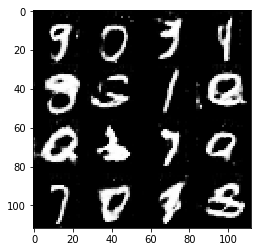

Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 1.8670
Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 1.1745
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 1.0420
Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 1.0783


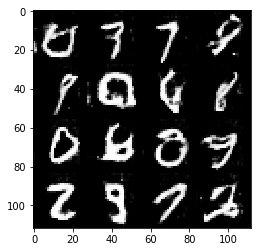

Epoch 2/2... Discriminator Loss: 0.9943... Generator Loss: 0.9673
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 1.8106
Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 1.5267
Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 2.5221


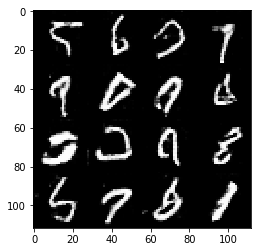

Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 1.5679
Epoch 2/2... Discriminator Loss: 0.8879... Generator Loss: 1.0887
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 0.9582
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 1.2369


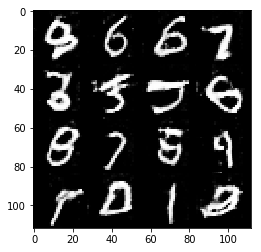

Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 0.6830
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 1.3964
Epoch 2/2... Discriminator Loss: 1.7591... Generator Loss: 0.3661
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 0.9792


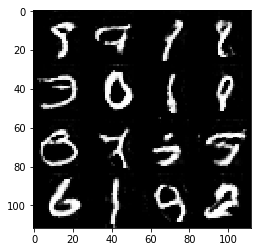

Epoch 2/2... Discriminator Loss: 0.7180... Generator Loss: 1.5689
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 0.9495
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 1.2925
Epoch 2/2... Discriminator Loss: 1.3340... Generator Loss: 0.6892


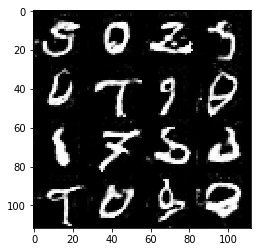

Epoch 2/2... Discriminator Loss: 0.8829... Generator Loss: 1.2516
Epoch 2/2... Discriminator Loss: 1.1953... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 1.1878... Generator Loss: 0.7218
Epoch 2/2... Discriminator Loss: 0.7613... Generator Loss: 1.4021


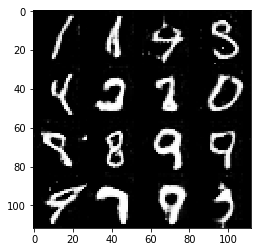

Epoch 2/2... Discriminator Loss: 1.0789... Generator Loss: 1.2849
Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 0.8280
Epoch 2/2... Discriminator Loss: 0.7678... Generator Loss: 1.3793


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    #tf.reset_default_graph()
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 4.7808
Epoch 1/1... Discriminator Loss: 0.4488... Generator Loss: 3.5251


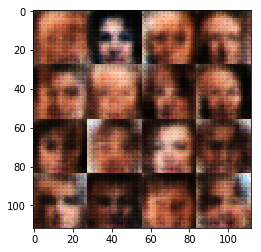

Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.4535
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 4.7691
Epoch 1/1... Discriminator Loss: 1.6211... Generator Loss: 0.3782


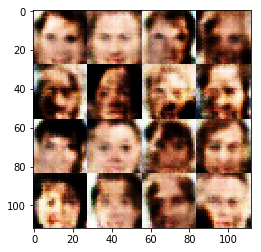

Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.5818
Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 2.2132
Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 3.0700
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.6008


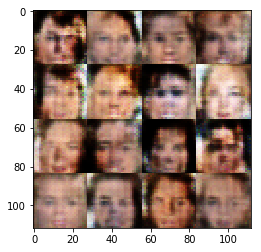

Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 2.0583


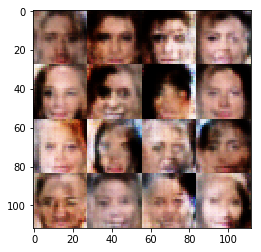

Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.6611


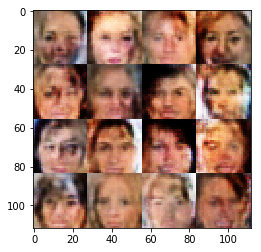

Epoch 1/1... Discriminator Loss: 0.4597... Generator Loss: 3.1755
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 1.7900


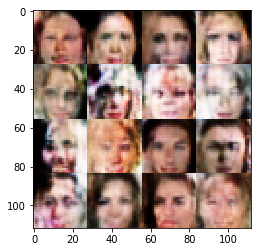

Epoch 1/1... Discriminator Loss: 0.4721... Generator Loss: 2.5418
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 2.0489
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.8574


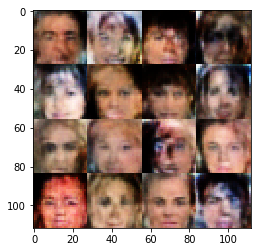

Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 1.7241
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.6849


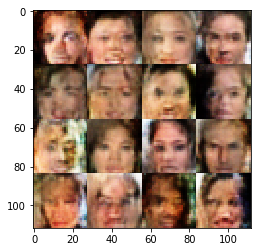

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 3.3295
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.5279


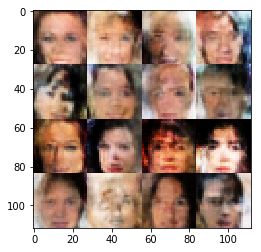

Epoch 1/1... Discriminator Loss: 2.0286... Generator Loss: 0.2367
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.2977


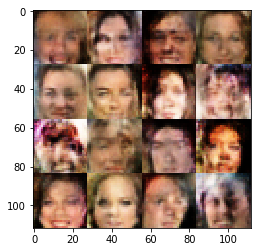

Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.4981


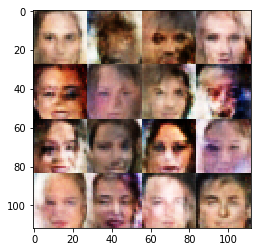

Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 2.3337
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.1795


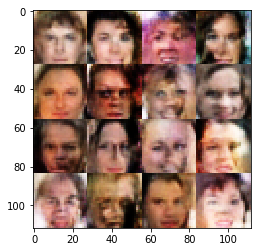

Epoch 1/1... Discriminator Loss: 0.7628... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.7386
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.7097


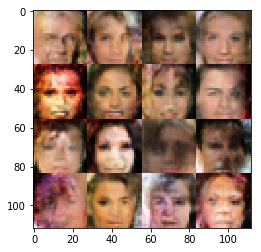

Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.3253
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 1.1498


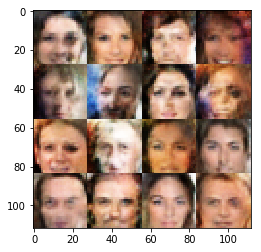

Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.4417


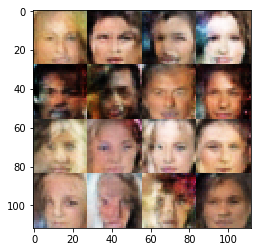

Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.9476


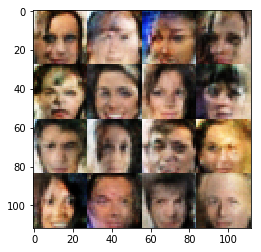

Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.5878... Generator Loss: 0.6328


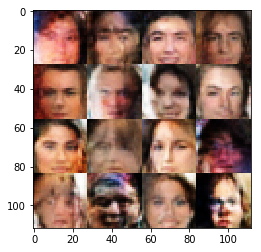

Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 0.9297


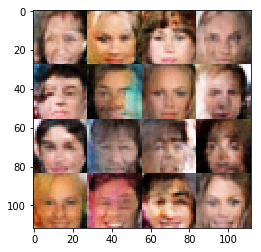

Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.5020


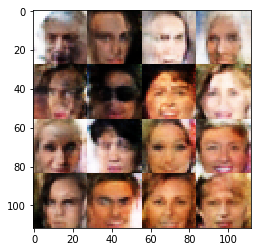

Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.7055... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.0941


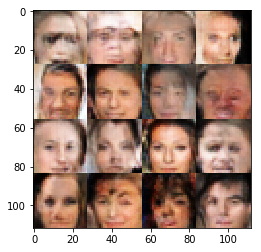

Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.6928


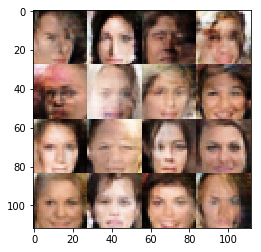

Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 1.7533
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.6987


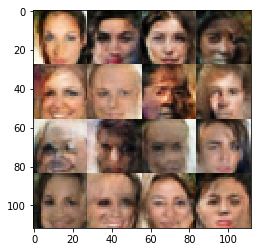

Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.3887
Epoch 1/1... Discriminator Loss: 1.6033... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8062


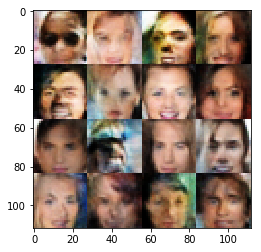

Epoch 1/1... Discriminator Loss: 1.6424... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.0676


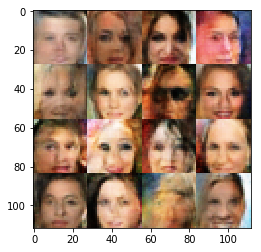

Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.5248
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.5028


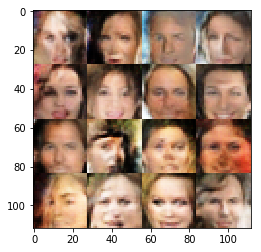

Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 4.3244
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.4509
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 2.1847
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.8575


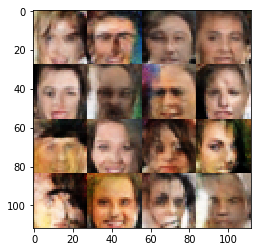

Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.7685
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.4777


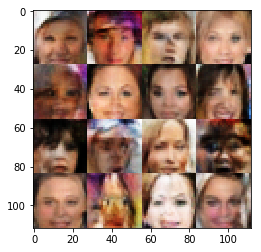

Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 1.3181
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.7724... Generator Loss: 0.3514


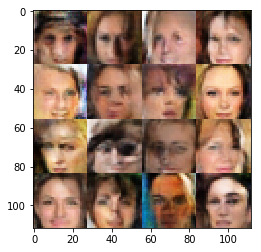

Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.6098


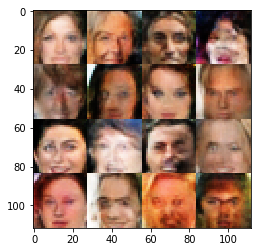

Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 1.6142... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 1.6247... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.9020


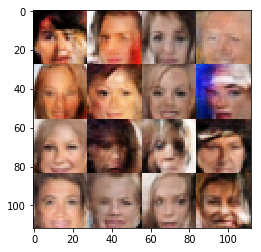

Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.2776
Epoch 1/1... Discriminator Loss: 1.7708... Generator Loss: 0.3435
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.5405


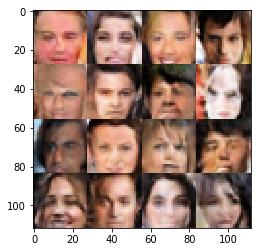

Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.4638


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    #tf.reset_default_graph()
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 1.9181... Generator Loss: 5.6929
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 2.0011
Epoch 1/2... Discriminator Loss: 0.6028... Generator Loss: 1.3951


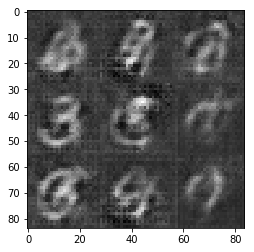

Epoch 2/2... Discriminator Loss: 0.5482... Generator Loss: 1.2491
Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 0.4687
Epoch 2/2... Discriminator Loss: 0.8860... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 0.1526... Generator Loss: 2.7363


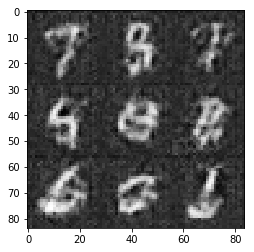

Epoch 2/2... Discriminator Loss: 0.5838... Generator Loss: 1.3877


In [17]:
batch_size = 256
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    #tf.reset_default_graph()
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.